<a href="https://colab.research.google.com/github/asupraja3/ml-ng-notebooks/blob/main/multiple_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Optional Lab: Multiple Variable Linear Regression (Andrew Ng style)
# ---------------------------------------------------------------
# Sections:
# 1) Data + helpers
# 2) Single prediction (loop vs. vector)
# 3) Cost with multiple variables
# 4) Gradient with multiple variables (loop version)
# 5) Batch Gradient Descent
# 6) Feature scaling (bonus)
# 7) Test run

import numpy as np
import math, copy

In [2]:
# ---------------------------------------------------------------
# 1) Data + helpers
#    We'll create a tiny synthetic dataset: price = w·x + b + noise
#    Features: [size(sqft), bedrooms, age]
#Fixes the random generator so you get the same random numbers every run
np.random.seed(0)
m = 120 #No. of training examples
#np.c_ stacks 1D arrays column-wise to form a 2D matrix.
# you get X_train with shape (120, 3) (m rows, n=3 features).
X_train = np.c_[                          # shape (m, n)
    np.random.uniform(800, 3500, m),      # size
    np.random.randint(1, 5, m),           # bedrooms
    np.random.uniform(0, 30, m)           # age
].astype(float) #ensures everything is float (bedrooms were ints).

# +25,000 per bedroom (the underscore just improves readability),−1,200 per year of age (older is cheaper).
true_w = np.array([200, 25_000, -1200.0]) # per-feature weights
# wihthout bias, The regression line is forced to go through the origin (0,0), which rarely matches real-world data.
true_b = 35_000.0 #The bias/intercept of the pricing model: a base price of $35,000.
noise  = np.random.normal(0, 20_000, m) #gaussian noise to make the data realistic (not perfectly linear).

# Computes target prices, for training purpose
#@ is already using NumPy’s optimized BLAS routines under the hood
y_train = X_train @ true_w + true_b + noise  # shape (m,)

def shapes(X, y):
    print(f"X shape={X.shape}  y shape={y.shape}")

shapes(X_train, y_train)

X shape=(120, 3)  y shape=(120,)


In [4]:
# ---------------------------------------------------------------
# 2) Single prediction (loop vs. vector)

def predict_single_loop(x, w, b):
    """
    Single example prediction using an explicit Python loop.
    x: (n,) feature vector for one house
    w: (n,) weight vector (per-feature coefficients)
    b: scalar bias/intercept
    returns: scalar prediction
    """
    p = 0.0                       # start accumulator at 0
    for j in range(len(w)):       # loop over each feature index
        p += x[j] * w[j]          # add feature * weight
    p += b                        # finally add the bias term
    return p                      # scalar prediction ŷ

def predict_single_vector(x, w, b):
    """Single example, vectorized dot product (no Python loop)."""
    return np.dot(x, w) + b       # x·w + b, faster and cleaner

def predict_batch(X, w, b):
    """
    Predict for ALL examples at once (vectorized).
    X: (m, n) feature matrix (m rows/examples, n features)
    w: (n,) weights
    b: scalar bias
    returns: (m,) vector of predictions for each row in X
    """
    return X @ w + b              # matrix–vector multiply + bias broadcasting

# quick check
x_vec  = X_train[0]                       # take the first training row → shape (n,)
w_init = np.zeros(X_train.shape[1])       # initialize weights to zeros → shape (n,)
b_init = 0.0                              # bias initialized to 0

# With zero weights and zero bias, prediction should be 0 in both cases.
print("Single (loop)  :", predict_single_loop(x_vec, w_init, b_init))
print("Single (vector):", predict_single_vector(x_vec, w_init, b_init))
print(x_vec, w_init, b_init)

Single (loop)  : 0.0
Single (vector): 0.0
[2.28179646e+03 1.00000000e+00 4.94082469e+00] [0. 0. 0.] 0.0


In [12]:
# ---------------------------------------------------------------
# 3) Compute cost with multiple variables

def compute_cost(X, y, w, b):
    """
    Compute the cost function J(w, b) for linear regression with multiple variables.
    Formula:
        J(w, b) = (1 / (2m)) * Σ_i [ (w·x^(i) + b) - y^(i) ]²

    Parameters:
    X : (m, n) feature matrix
        m = number of training examples, n = number of features
    y : (m,) target values
    w : (n,) weight vector
    b : scalar bias

    Returns:
    cost : scalar, the average squared error cost
    """
    m = X.shape[0]          # number of training examples
    cost = 0.0              # accumulator for total squared error
    for i in range(m):      # loop over each training example
        # Prediction for the i-th example: dot product of row i with w, plus bias
        f_wb_i = np.dot(X[i], w) + b
        # Squared error for this example, add to running total
        cost += (f_wb_i - y[i])**2

    # Average the squared error over all examples, multiply by 1/2 as per formula
    return cost / (2*m)


In [14]:
# ---------------------------------------------------------------
# 4) Compute gradient with multiple variables (loop version)

def compute_gradient(X, y, w, b):
    """
    Compute the gradient (partial derivatives) of the cost function J(w, b)
    for linear regression with multiple features.

    Formulas:

        dj_dw_j = (1/m) * Σ_i [ (w·x^(i) + b - y^(i)) * x_j^(i) ]
        dj_db   = (1/m) * Σ_i [ (w·x^(i) + b - y^(i)) ]

    Parameters:
        X : (m, n) feature matrix
        y : (m,) target vector
        w : (n,) weights vector
        b : scalar bias
    Returns:
        dj_dw : (n,) gradient vector w.r.t. weights
        dj_db : scalar gradient w.r.t. bias
    """
    m, n = X.shape                 # m = number of examples, n = number of features
    dj_dw = np.zeros(n)             # initialize gradient for weights to zero
    dj_db = 0.0                     # initialize gradient for bias to zero

    # Outer loop over each training example
    for i in range(m):
        # Prediction error for i-th example
        err_i = (np.dot(X[i], w) + b) - y[i]   # scalar: y_hat(i) - y(i)

        # Accumulate gradient for bias
        dj_db += err_i

        # Inner loop over each feature
        for j in range(n):
            # Accumulate gradient for weight j
            dj_dw[j] += err_i * X[i, j]

    # Average over all examples
    dj_dw /= m
    dj_db /= m

    return dj_dw, dj_db


In [15]:
# (Optional) Fully vectorized gradient for comparison
def compute_gradient_vectorized(X, y, w, b):
    m = X.shape[0]
    # Compute the prediction errors for all m samples at once
    # Shape: (m,) — one error value per training example
    errors = X @ w + b - y

    # Compute gradient w.r.t. weights for all features at once
    # X.T shape: (n, m), errors shape: (m,)
    # Result shape: (n,)
    dj_dw = (X.T @ errors) / m

    # Compute gradient w.r.t. bias (scalar)
    # Just the mean of all errors
    dj_db = np.sum(errors) / m

    return dj_dw, dj_db

In [16]:
# ---------------------------------------------------------------
# 5) Batch Gradient Descent

def gradient_descent(X, y, w_in, b_in, alpha, num_iters,
                     cost_function=compute_cost,
                     gradient_function=compute_gradient):
    """
    Perform batch gradient descent to minimize J(w, b).

    Update rules (each iteration):
        w := w - alpha * dj_dw
        b := b - alpha * dj_db

    Parameters:
    X : (m, n) feature matrix
    y : (m,)   target vector
    w_in : (n,) initial weights
    b_in : scalar initial bias
    alpha : float learning rate (step size)
    num_iters : int number of gradient descent iterations
    cost_function : callable, computes J(w, b) on (X, y)
    gradient_function : callable, returns (dj_dw, dj_db) on (X, y, w, b)
                        - can be loop version (compute_gradient)
                        - or vectorized version (compute_gradient_vectorized)

    Returns:
    w : (n,) learned weights after num_iters
    b : scalar learned bias after num_iters
    J_history : list of cost values per iteration (for plotting/diagnostics)
    """

    # Make safe copies so caller's w_in/b_in aren't modified in-place
    # (requires: import copy, import math)
    w = copy.deepcopy(w_in)     # ensures original weights remain unchanged
    b = float(b_in)             # ensure plain Python float for arithmetic

    J_history = []              # keep track of cost J each iteration (optional)

    for i in range(num_iters):
        # 1) Compute gradients at current (w, b)
        #    dj_dw: (n,) partial derivatives w.r.t. each weight
        #    dj_db: scalar partial derivative w.r.t. bias
        dj_dw, dj_db = gradient_function(X, y, w, b)

        # 2) Parameter update step (move against the gradient)
        w -= alpha * dj_dw
        b -= alpha * dj_db

        # 3) (Optional) Track cost for inspection/plotting
        #    Guard to avoid huge memory if num_iters is extremely large
        if i < 100000:
            J_history.append(cost_function(X, y, w, b))

        # 4) Progress print ~10 times total across the run
        if (i + 1) % max(1, math.ceil(num_iters / 10)) == 0:
            print(f"iter {i+1:4d}: J={J_history[-1]:.2f}")

    return w, b, J_history


In [18]:
# ---------------------------------------------------------------
# 6) Feature scaling (bonus, as in the course)

def feature_normalize(X):
    """
    Perform Z-score normalization (standardization) of features column-wise.

    Formula for each column j:
        X_norm[:, j] = (X[:, j] - mu[j]) / sigma[j]

    Purpose:
        - Centers each feature around 0 mean and scales it to unit variance.
        - Helps gradient descent converge faster by keeping feature values
          in similar ranges.

    Parameters:
    X : (m, n) feature matrix
        m = number of training examples
        n = number of features

    Returns:
    X_norm : (m, n) normalized feature matrix
    mu     : (n,) mean of each feature
    sigma  : (n,) standard deviation of each feature
    """
    # 1) Compute mean of each feature (column)
    # axis=0 → mean along rows, gives one mean per column
    mu = np.mean(X, axis=0)

    # 2) Compute standard deviation of each feature (column)
    # ddof=0 → population standard deviation
    sigma = np.std(X, axis=0, ddof=0)

    # 3) Apply Z-score normalization:
    #    subtract mean and divide by standard deviation for each feature
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma


In [19]:
# ---------------------------------------------------------------
# 7) Test run (with/without scaling)

# ---------------------------
# Train WITHOUT feature scaling
# ---------------------------
print("\n--- Training WITHOUT feature scaling ---")

# Initialize parameters (weights=0, bias=0)
w0 = np.zeros(X_train.shape[1])    # shape (n,)
b0 = 0.0                           # scalar

# Run gradient descent
# Note:
# - alpha (learning rate) must be VERY small (1e-9) because features are on large, different scales
# - num_iters = 5000 to allow slow convergence
w_final, b_final, J_hist = gradient_descent(
    X_train, y_train, w0, b0,
    alpha=1e-9,          # tiny step since features are unscaled
    num_iters=5000
)

# Show learned parameters
print(f"\nLearned params (no scaling):\n"
      f"b = {b_final:.2f}\n"
      f"w = {w_final}")

# ---------------------------
# Train WITH feature scaling
# ---------------------------
print("\n--- Training WITH feature scaling ---")

# Apply Z-score normalization to features
Xn, mu, sigma = feature_normalize(X_train)

# Initialize parameters again
w0 = np.zeros(Xn.shape[1])    # shape (n,)
b0 = 0.0

# Run gradient descent
# Note:
# - After scaling, we can safely use a MUCH larger learning rate (0.1)
# - Fewer iterations are needed for convergence
w_scaled, b_scaled, J_hist_s = gradient_descent(
    Xn, y_train, w0, b0,
    alpha=0.1,           # larger step size works well after scaling
    num_iters=400
)

# Show learned parameters for scaled data
print(f"\nLearned params (scaled features):\n"
      f"b = {b_scaled:.2f}\n"
      f"w = {w_scaled}")

# ---------------------------
# Compare predictions
# ---------------------------
# Example house: 1800 sqft, 3 bedrooms, 10 years old
sample = np.array([1800.0, 3.0, 10.0])

# Prediction using the model trained without scaling
pred_no_scale = predict_single_vector(sample, w_final, b_final)

# Prediction using the model trained with scaling
# Important: we must scale the sample using the SAME mu and sigma from training
sample_n = (sample - mu) / sigma
pred_scaled = predict_single_vector(sample_n, w_scaled, b_scaled)

# Show predictions
print(f"\nSample prediction (no scaling model):  {pred_no_scale:,.0f}")
print(f"Sample prediction (scaled model):     {pred_scaled:,.0f}")



--- Training WITHOUT feature scaling ---
iter  500: J=1933046310.00
iter 1000: J=1162724588.61
iter 1500: J=1158440907.26
iter 2000: J=1158415127.02
iter 2500: J=1158413013.66
iter 3000: J=1158411031.87
iter 3500: J=1158409050.82
iter 4000: J=1158407069.79
iter 4500: J=1158405088.78
iter 5000: J=1158403107.79

Learned params (no scaling):
b = 0.15
w = [231.98238911   0.54938796   1.5300872 ]

--- Training WITH feature scaling ---
iter   40: J=220020683.41
iter   80: J=188737704.16
iter  120: J=188730628.88
iter  160: J=188730627.25
iter  200: J=188730627.25
iter  240: J=188730627.25
iter  280: J=188730627.25
iter  320: J=188730627.25
iter  360: J=188730627.25
iter  400: J=188730627.25

Learned params (scaled features):
b = 507148.63
w = [151556.46913062  28455.55208226 -11993.44533027]

Sample prediction (no scaling model):  417,585
Sample prediction (scaled model):     457,379


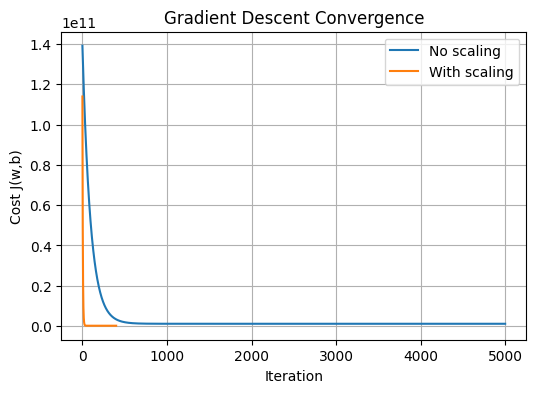

In [20]:
#  1) Plot cost convergence (with vs without scaling)
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(J_hist, label="No scaling")
plt.plot(J_hist_s, label="With scaling")
plt.xlabel("Iteration")
plt.ylabel("Cost J(w,b)")
plt.title("Gradient Descent Convergence")
plt.grid(True)
plt.legend()
plt.show()


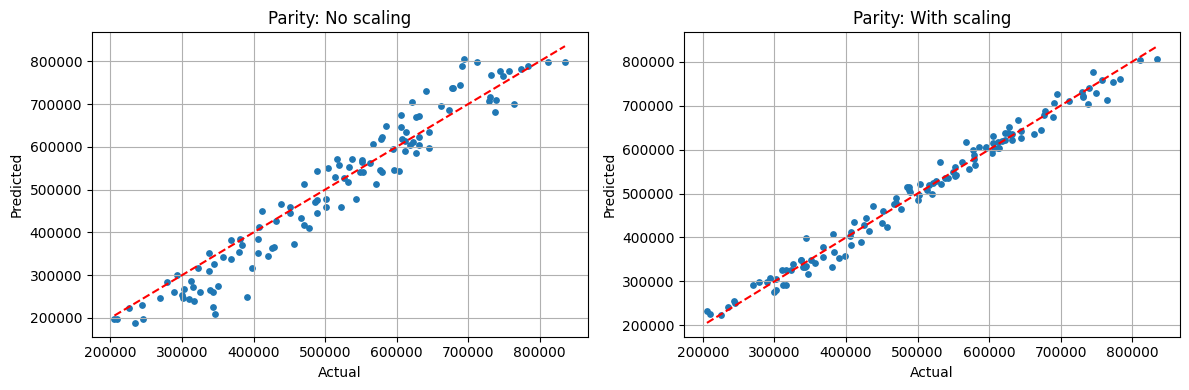

In [21]:
#  3) Parity plot: predicted vs actual (how good is the fit?)
# Predictions using both models
y_pred_no_scale = predict_batch(X_train, w_final, b_final)
y_pred_scaled   = predict_batch(Xn, w_scaled, b_scaled)  # uses scaled X

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(y_train, y_pred_no_scale, s=15)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()], 'r--')
plt.title("Parity: No scaling")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(y_train, y_pred_scaled, s=15)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()], 'r--')
plt.title("Parity: With scaling")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)

plt.tight_layout()
plt.show()


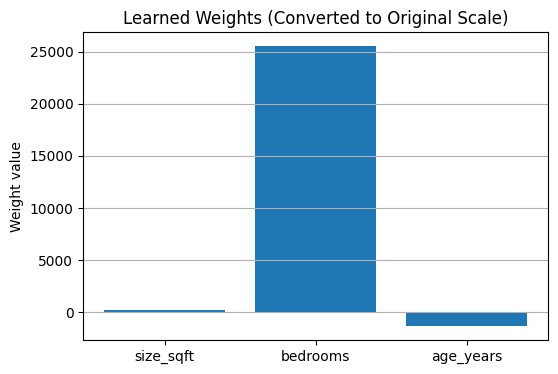


True vs. learned weights (original scale)
True   : [  200. 25000. -1200.]
Learned: [  196.9 25522.4 -1358.4]
Bias:   true = 35000.0  | learned ≈ 39929.3


In [22]:
# 6) Feature importance bar chart (from unscaled params)
feature_names = ["size_sqft", "bedrooms", "age_years"]

# use unscaled version of the scaled model for fair comparison
w_unscaled = w_scaled / sigma
b_unscaled = b_scaled - np.dot(w_unscaled, mu)

plt.figure(figsize=(6,4))
plt.bar(feature_names, w_unscaled)
plt.title("Learned Weights (Converted to Original Scale)")
plt.ylabel("Weight value")
plt.grid(True, axis='y')
plt.show()

print("\nTrue vs. learned weights (original scale)")
print("True   :", true_w)
print("Learned:", np.round(w_unscaled, 1))
print("Bias:   true =", true_b, " | learned ≈", round(b_unscaled, 1))
